In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import os
import sys
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow as tf
pd.set_option("display.max_columns",None)

In [ ]:
df=pd.read_csv("/content/sample_data/Net_generation_United_States_all_sectors_monthly.csv",sep='\t')

In [ ]:
df=df.drop(df.index[0:5])


In [ ]:
columns_1 = [
    "Month",
    "all_fuels",
    "coal",
    "natural_gas",
    "nuclear",
    "conventional_hydroelectric",
    "wind",
    "all_solar"
]


In [ ]:
df["Net generation United States all sectors monthly"].str.split(",").str[3]
df[columns_1]=0


In [ ]:
for items,i in zip(columns_1,range(len(columns_1))):
    df[f"{items}"] = df["Net generation United States all sectors monthly"].astype(str).str.split(",").str[i]

df=df.drop("Net generation United States all sectors monthly",axis=1)

In [ ]:
for col in columns_1:
  if col != "Month":
    df[col]=pd.to_numeric(df[col],errors="coerce")
  else:
    df[col]=pd.to_datetime(df[col])

<ipython-input-196-ac97e5960525>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
df.reset_index(drop=True)
df.columns

Index(['Month', 'all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'all_solar'],
      dtype='object')

In [ ]:
df.head()
df.head()
months_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

list_1=["month","year"]
for month_year in list_1:
  df[f"{month_year}"]=df["Month"].dt.__getattribute__(month_year)


In [ ]:
df["month"]=[months_dict[i] for i in df.month.values]

In [ ]:
df.drop(["Month"],axis=1,inplace=True)

In [ ]:
df.isnull().sum()
df.duplicated().sum()
df.dropna()
df.drop_duplicates()
df.columns

Index(['all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'all_solar', 'month', 'year'],
      dtype='object')

In [ ]:
#sns.pairplot(df,kind="scatter",palette="viridis",hue="all_solar")

In [ ]:
numerical_cols=df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols=df.select_dtypes("object").columns.tolist()


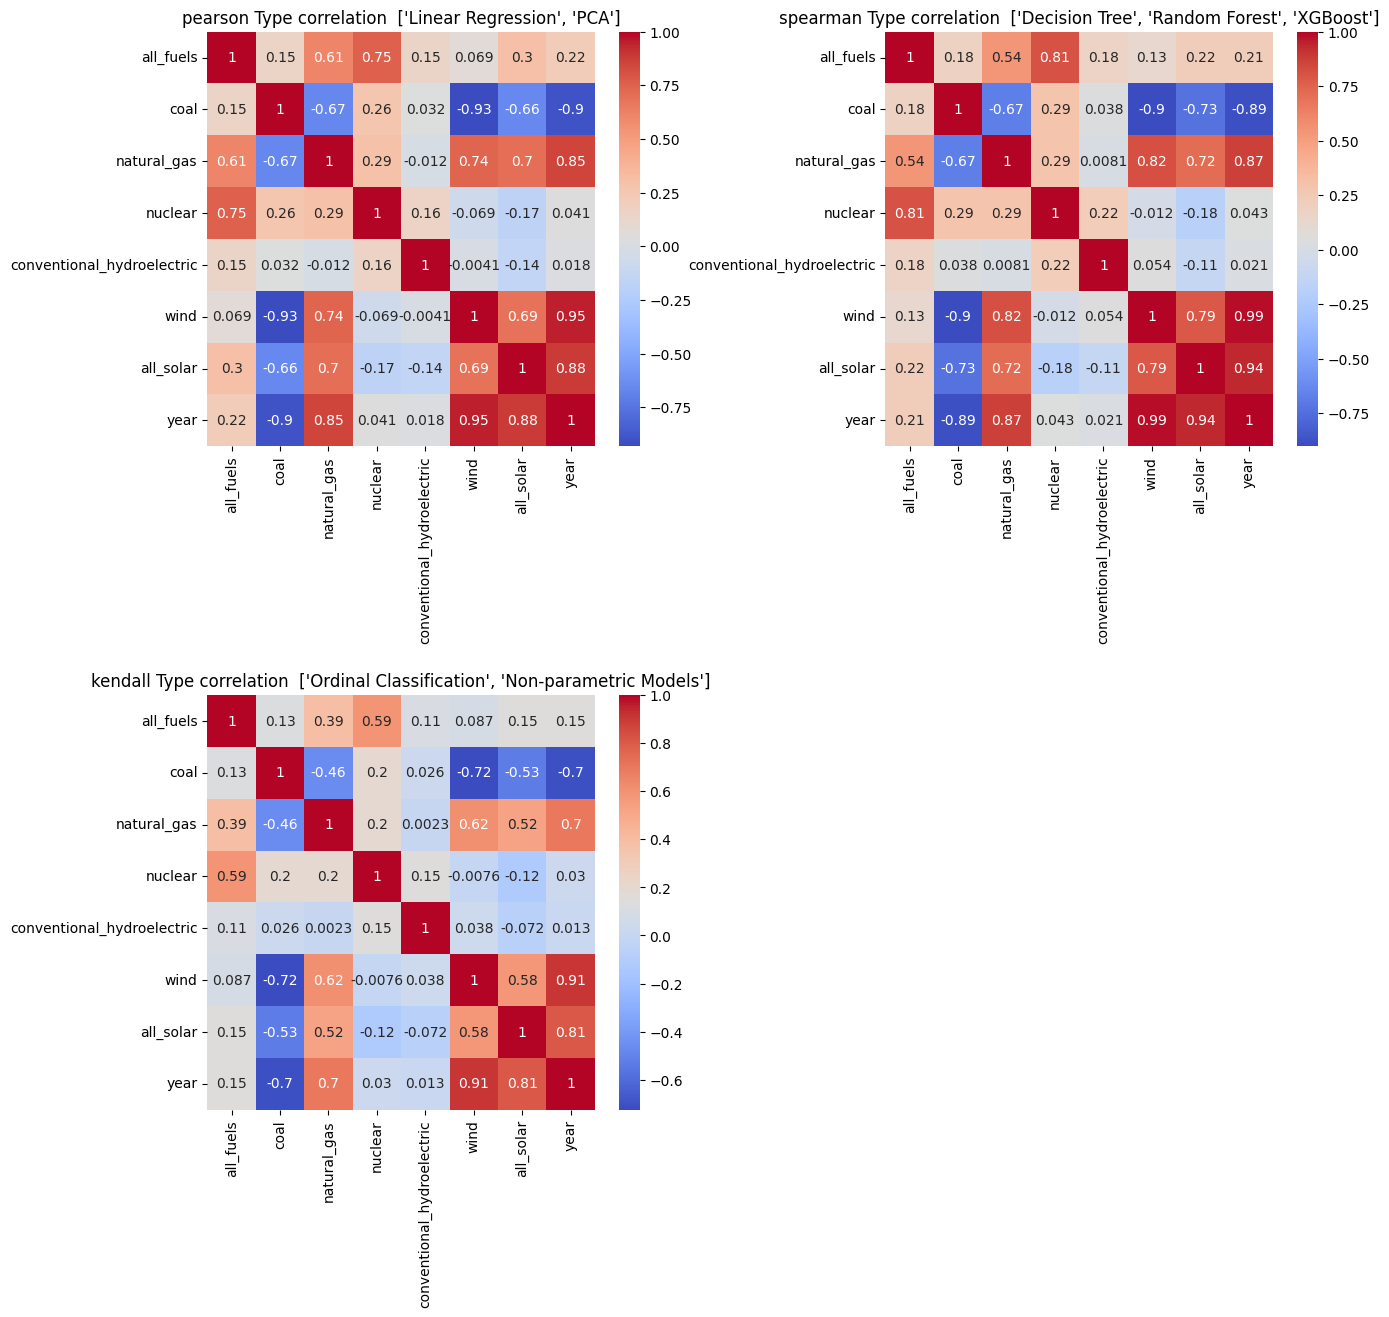

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(15,14))
axes=axes.flatten()
correlation_methods = ['pearson', 'spearman', 'kendall']
correlation_models = [
    ["Linear Regression", "PCA"],
    ["Decision Tree", "Random Forest", "XGBoost"],
    ["Ordinal Classification", "Non-parametric Models"]
]

plt.subplots_adjust(wspace=0.4,hspace=0.6)
for ax in axes[3:4]:
  plt.delaxes(ax)






for ax,corr,model in zip(axes,correlation_methods,correlation_models):
  if ax.get_visible():
    fig=sns.heatmap(df[numerical_cols].corr(method=f"{corr}"),ax=ax,annot=True,cmap="coolwarm")
    fig.set_title(f"{corr} Type correlation  {model}")

In [ ]:
df.drop("all_solar",inplace=True,axis=1)


In [ ]:
df.columns

Index(['all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'month', 'year'],
      dtype='object')

In [ ]:
df.columns

train_df=df
train_df=train_df.dropna()
df=df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse_output=False)


In [ ]:
encoded_cols = pd.DataFrame(encoder.fit_transform(train_df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
encoded_cols = encoded_cols.reset_index(drop=True)
train_df = pd.concat([train_df.reset_index(drop=True), encoded_cols], axis=1)



In [ ]:
train_df = train_df.drop("month", axis=1)

In [ ]:
df.columns

Index(['all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'month', 'year'],
      dtype='object')

In [ ]:
#Lets train  in random forest model
numerical_cols=train_df.select_dtypes(include=["number"]).columns.tolist()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error,mean_absolute_percentage_error




scaler=StandardScaler()
imputer=SimpleImputer(strategy="median")

train_df[numerical_cols]=imputer.fit_transform(train_df[numerical_cols])




In [ ]:
df=df.drop("month",axis=1)

In [ ]:
target_col="wind"

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="wind"
combined_dataframe,error_dataframe=random_forest(target_col)
error_dataframe


,Mae,Mape,r2 Score
0,1546.740834,0.128885,0.952653


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,30971.162161,35751.09063
1,509.134020,431.24200
2,16251.932425,19846.43699
3,35870.781169,33767.53068
4,10302.076442,10451.56190


In [ ]:
combined_dataframe.columns

Index(['Predicted_data', 'Actual_data'], dtype='object')

In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="coal"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


,Mae,Mape,r2 Score
0,7106.331721,0.072255,0.937932


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,59154.873808,57426.34728
1,150513.354185,149735.48400
2,96036.983401,115129.45572
3,67517.287469,73463.10379
4,136431.806043,138311.15723


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="natural_gas"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


,Mae,Mape,r2 Score
0,6750.44529,0.082925,0.963501


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,126837.925458,122433.25919
1,54229.768996,37966.92700
2,154670.244915,162000.63402
3,155826.720054,155516.99607
4,74736.491701,65923.98289


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="nuclear"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe



,Mae,Mape,r2 Score
0,2015.7615,0.030475,0.727724


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,62223.71636,62749.318
1,60026.80206,61272.407
2,70752.57320,72282.467
3,69850.40005,65715.420
4,64791.33185,64789.078


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="conventional_hydroelectric"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


,Mae,Mape,r2 Score
0,2610.332989,0.119086,0.21391


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,19881.896202,19373.24966
1,18774.173150,17472.88900
2,22742.974029,22016.90536
3,20842.116150,25987.79518
4,23505.808662,24131.22605


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  scaler.fit_transform(X)
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  regressor.fit(X_train,y_train)




  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(regressor.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)


  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])


  return combined_dataframe,error_dataframe


target_col="all_fuels"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


,Mae,Mape,r2 Score
0,9502.181591,0.027579,0.904102


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,319099.052763,314309.52061
1,302546.494040,282940.19800
2,398128.133511,408352.14970
3,348435.129417,379133.82357
4,320415.466214,313126.60705


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for Random Forest Model for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
#from tensorflow.keras.

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="all_fuels"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 336772.1250 - mean_absolute_error: 336772.1250 - val_loss: 336847.7500 - val_mean_absolute_error: 336847.7500
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 341881.7500 - mean_absolute_error: 341881.7500 - val_loss: 336846.1250 - val_mean_absolute_error: 336846.1250
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 338698.2500 - mean_absolute_error: 338698.2500 - val_loss: 336843.4688 - val_mean_absolute_error: 336843.4688
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 338685.1562 - mean_absolute_error: 338685.1562 - val_loss: 336839.2500 - val_mean_absolute_error: 336839.2500
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 336999.1250 - mean_absolute_error: 336999.1250 - val_loss: 336832.6875 - val_mean_absolute_error: 336832.6875
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 337424.2500 - mean_absolute_error: 337424.2500 - val_loss: 336822.7188 - val_mean_absolute_error

,Mae,Mape,r2 Score
0,2244.184187,0.006735,0.992421


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,313096.56250,314309.52061
1,288471.46875,282940.19800
2,407352.96875,408352.14970
3,374211.84375,379133.82357
4,313259.31250,313126.60705


from matplotlib import pyplot as plt
_df_0['Predicted_data'].plot(kind='hist', bins=20, title='Predicted_data')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Actual_data'].plot(kind='hist', bins=20, title='Actual_data')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Predicted_data', y='Actual_data', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Predicted_data'].plot(kind='line', figsize=(8, 4), title='Predicted_data')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Actual_data'].plot(kind='line', figsize=(8, 4), title='Actual_data')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="coal"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 120585.2656 - mean_absolute_error: 120585.2656 - val_loss: 118584.9844 - val_mean_absolute_error: 118584.9844
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 119906.3047 - mean_absolute_error: 119906.3047 - val_loss: 118584.0312 - val_mean_absolute_error: 118584.0312
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 124313.2266 - mean_absolute_error: 124313.2266 - val_loss: 118582.4297 - val_mean_absolute_error: 118582.4297
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 119649.3281 - mean_absolute_error: 119649.3281 - val_loss: 118579.8984 - val_mean_absolute_error: 118579.8984
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 122978.7969 - mean_absolute_error: 122978.7969 - val_loss: 118575.9141 - val_mean_absolute_error: 118575.9141
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 124056.1094 - mean_absolute_error: 124056.1094 - val_loss: 118569.7266 - val_mean_absolute_error

,Mae,Mape,r2 Score
0,3242.166919,0.034211,0.987783


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,54077.640625,57426.34728
1,154198.328125,149735.48400
2,115216.500000,115129.45572
3,76535.218750,73463.10379
4,135706.375000,138311.15723


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="natural_gas"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 97766.4688 - mean_absolute_error: 97766.4688 - val_loss: 100337.9453 - val_mean_absolute_error: 100337.9453
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 99577.1016 - mean_absolute_error: 99577.1016 - val_loss: 100336.1797 - val_mean_absolute_error: 100336.1797
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 95389.5000 - mean_absolute_error: 95389.5000 - val_loss: 100333.2266 - val_mean_absolute_error: 100333.2266
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 98531.3828 - mean_absolute_error: 98531.3828 - val_loss: 100328.3359 - val_mean_absolute_error: 100328.3359
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 99327.6406 - mean_absolute_error: 99327.6406 - val_loss: 100320.5234 - val_mean_absolute_error: 100320.5234
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 98151.7031 - mean_absolute_error: 98151.7031 - val_loss: 100308.6562 - val_mean_absolute_error: 100308.656

,Mae,Mape,r2 Score
0,3147.418012,0.039588,0.991881


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,118330.796875,122433.25919
1,44080.500000,37966.92700
2,161004.718750,162000.63402
3,154690.468750,155516.99607
4,64648.308594,65923.98289


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="nuclear"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 66066.6172 - mean_absolute_error: 66066.6172 - val_loss: 65247.7500 - val_mean_absolute_error: 65247.7500
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 66001.1094 - mean_absolute_error: 66001.1094 - val_loss: 65246.3789 - val_mean_absolute_error: 65246.3789
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 65708.0234 - mean_absolute_error: 65708.0234 - val_loss: 65244.2422 - val_mean_absolute_error: 65244.2422
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 66118.6562 - mean_absolute_error: 66118.6562 - val_loss: 65240.7656 - val_mean_absolute_error: 65240.7656
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 65967.7734 - mean_absolute_error: 65967.7734 - val_loss: 65235.1289 - val_mean_absolute_error: 65235.1289
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 65876.3047 - mean_absolute_error: 65876.3047 - val_loss: 65226.3594 - val_mean_absolute_error: 65226.3594
Epoch 7/10

,Mae,Mape,r2 Score
0,2955.198899,0.043999,0.38187


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,60324.183594,62749.318
1,59667.417969,61272.407
2,68922.562500,72282.467
3,67956.531250,65715.420
4,64773.597656,64789.078


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="conventional_hydroelectric"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 22057.3398 - mean_absolute_error: 22057.3398 - val_loss: 21658.9922 - val_mean_absolute_error: 21658.9922
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 22356.4629 - mean_absolute_error: 22356.4629 - val_loss: 21657.8281 - val_mean_absolute_error: 21657.8281
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 22749.2109 - mean_absolute_error: 22749.2109 - val_loss: 21655.9922 - val_mean_absolute_error: 21655.9922
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 22267.8164 - mean_absolute_error: 22267.8164 - val_loss: 21653.0449 - val_mean_absolute_error: 21653.0449
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22480.8633 - mean_absolute_error: 22480.8633 - val_loss: 21648.3887 - val_mean_absolute_error: 21648.3887
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 22441.9395 - mean_absolute_error: 22441.9395 - val_loss: 21641.1934 - val_mean_absolute_error: 21641.1934
Epoch 7/10

,Mae,Mape,r2 Score
0,2879.854606,0.123327,-0.063504


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,21349.224609,19373.24966
1,21580.185547,17472.88900
2,23984.316406,22016.90536
3,18842.298828,25987.79518
4,21414.195312,24131.22605


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
def random_forest(target_col):
  input_col=[col for col in df.columns.values if col != target_col]
  X=train_df[input_col]
  y=train_df[target_col]
  X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
  X_train,X_temp,y_train,y_temp=train_test_split(X,y,random_state=42,train_size=0.6)
  X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,random_state=42,test_size=0.5)
  model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1)

  ])

  early_stopping=EarlyStopping(patience=10,restore_best_weights=True )

  optimizer = Adam()
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=["mean_absolute_error"])
  history = model.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_val, y_val),epochs=1000, batch_size=32)



  #Lets make the prediction for this particular dataset
  predicted_dataset=pd.DataFrame(model.predict(X_test)).reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  combined_dataframe=pd.concat([predicted_dataset,y_test],axis=1)
  combined_dataframe.columns = ["Predicted_data", "Actual_data"]
  #Lets make a dataframe out of errors
  mae=mean_absolute_error(y_test,predicted_dataset)
  mape=mean_absolute_percentage_error(y_test,predicted_dataset)
  r2=r2_score(y_test,predicted_dataset)

  dict1={


         "Mae":mae,
         "Mape":mape,
         "r2 Score":r2

  }

  error_dataframe=pd.DataFrame(dict1,index=[0])

  return combined_dataframe,error_dataframe


target_col="wind"
combined_dataframe,error_dataframe=random_forest(target_col)


error_dataframe


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 14571.2627 - mean_absolute_error: 14571.2627 - val_loss: 16151.2109 - val_mean_absolute_error: 16151.2109
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 15009.1299 - mean_absolute_error: 15009.1299 - val_loss: 16150.0752 - val_mean_absolute_error: 16150.0752
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 15089.6992 - mean_absolute_error: 15089.6992 - val_loss: 16148.2305 - val_mean_absolute_error: 16148.2305
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14627.0791 - mean_absolute_error: 14627.0791 - val_loss: 16145.2158 - val_mean_absolute_error: 16145.2158
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13205.4941 - mean_absolute_error: 13205.4941 - val_loss: 16140.4092 - val_mean_absolute_error: 16140.4092
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14855.4082 - mean_absolute_error: 14855.4082 - val_loss: 16132.9082 - val_mean_absolute_error: 16132.9082
Epoch 7/10

,Mae,Mape,r2 Score
0,1349.277506,0.208515,0.974836


In [ ]:
combined_dataframe.head()

,Predicted_data,Actual_data
0,33084.328125,35751.09063
1,941.300354,431.24200
2,18542.412109,19846.43699
3,30850.445312,33767.53068
4,9929.005859,10451.56190


In [ ]:
combinde_melted_dataframe=combined_dataframe.reset_index().melt(
    id_vars="index",
    value_vars=['Predicted_data', 'Actual_data'],
    var_name="Type of Data",
    value_name="Value"
)

ax=px.line(combinde_melted_dataframe,x="index",y="Value",color="Type of Data",title=f"Actual vs Predicted Data for ANN for {target_col} energy",line_shape="spline")
ax.update_layout(
    height=400,
    width=800,
    xaxis_title="Index",
    yaxis_title="Predicted and actual Values"




)
ax.show()

In [ ]:
df.columns

Index(['all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'year'],
      dtype='object')

In [ ]:
df.columns

Index(['all_fuels', 'coal', 'natural_gas', 'nuclear',
       'conventional_hydroelectric', 'wind', 'year'],
      dtype='object')

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],  
}
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)